# Lab 3: Non-parametric Classifiers
Machine Learning 2020/2021 <br>
Ruben Wiersma and Gosia Migut

Revised by Lisette Veldkamp

**WHAT** This nonmandatory lab consists of several programming and insight exercises/questions on k-nn density estimation.

**WHY** The exercises are meant to familiarize yourself with the basic concepts of non-parametric classifiers.

**HOW** Follow the exercises in this notebook either on your own or with a fellow student. If you want to skip right to the questions and exercises, find the $\rightarrow$ symbol. Use [Mattermost][1] to discuss questions with your peers. For additional questions and feedback please consult the TAs during the lab session. 

[1]: https://mattermost.ewi.tudelft.nl/
$\newcommand{\q}[1]{\rightarrow \textbf{Question #1}}$
$\newcommand{\ex}[1]{\rightarrow \textbf{Exercise #1}}$

## K-Nearest Neighbours

Last week, you got acquainted with parametric classifiers. You described a distribution using only a few parameters (mean and standard deviation) and tried to find the values for those parameters that best fit the data. This week, you will work on non-parametric classifiers. As the name implies, these classifiers do not use parameters to describe their data. Instead, they directly use training data in the classification process, or set up rules to classify new samples.

A popular example of non-parametric classifiers is the K-Nearest Neighbours (K-NN) classifier. In this exercise, you will find out how it works by implementing it yourself and you'll get to know in what circumstances to use it. In this assignment, we will walk you through the following steps in the K-NN algorithm:

1. Load data: Open the dataset from CSV and split into test/train datasets.
2. Similarity: Calculate the distance between two data instances.
3. Nearest Neighbours: Locate k most similar data instances.
4. Majority vote: Get the neighbours to vote on the class of the test points.
5. Accuracy: Summarize the accuracy of predictions.

Let's get started!

### 1. Load data
In this notebook we will work with the Iris dataset again.

In [12]:
import numpy as np
from sklearn import datasets # to load the dataset
from sklearn.model_selection import train_test_split #to split in train and test set

seed = 20
# load the data and create the training and test sets
iris = datasets.load_iris()
# X is the feature vectors of the data points, and Y is the target (ground truth) class for those data points 
X_train, X_test, Y_train, Y_test = train_test_split(iris.data, iris.target, test_size=0.4, random_state=seed) 

$\ex{1.1}$ Print and plot the data to understand what you will be classifying. You can plot points using Matplotlib's [scatter](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.scatter.html) function. We have already imported `pyplot` as `plt`. This means you can call the `scatter` function with `plt.scatter(x, y, ...)`.

__Hint__ each sample has four features (corresponding to the length and the width of the sepals and petals), you can just plot two of them to get a basic idea of the data. The feature names can be accessed in the list *iris_feature_names*.<br>
__Hint__ use the `c=Y_train` parameter to colour each point with its class.

(90, 4)


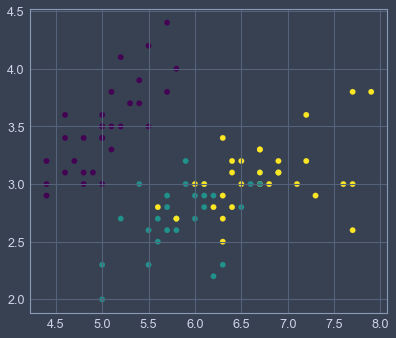

In [2]:
from matplotlib import pyplot as plt
print(X_train.shape)

from jupyterthemes import jtplot
jtplot.style(theme = "oceans16")

# START ANSWER
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train)
# END ANSWER

$\q{1.1}$ Would it work to classify this dataset with a parametric classifier? Why? Why not?

yes, for two reasons: 1. the samples are regular (not mess up or overlap) which we can assume models to fit them; 2. samples in the dataset are independent from each other.

But, for when to use non-parametric or parametric classifier is hard to decide. Sometimes, we try several classifiers from both methods to decide which one is suitable.

### 2. Similarity

Next, we will create a function to compute distance between two points $ \mathbf{p}$ and $\mathbf{q} $. We will use the often used euclidean distance to find the nearest neighbours of a point.

$\ex{2.1}$ Complete the `euclidean` function. This function should compute the euclidean distance between two points (i.e. feature vectors). 

**Note:** As we are working with feature vectors, the "$\cdot$" depicts a dotproduct:

$$
d(\mathbf{p}, \mathbf{q}) = \sqrt{(\mathbf{p} - \mathbf{q})\cdot(\mathbf{p} - \mathbf{q})}
$$

__Hint__ You might know a more specific formulation of this as $|\mathbf{p}| = \sqrt{p_1^2 + p_2^2}$

In [3]:
from scipy.spatial import distance

def euclidean(p, q):
    """
    Computes the euclidean distance between point p and q.
    :param p: point p as a numpy array.
    :param q: point q as a numpy array.
    :return: distance as float.
    """
    
    dist = 0
    # START ANSWER
    dist = np.sqrt(np.dot(p-q, p-q))
    # END ANSWER
    return dist

# check whether your algorithm is correct
a = np.array([2, 4, 8])
b = np.array([3, 5, 9])

print('The output of your algorithm:', euclidean(a, b))
assert np.isclose(euclidean(a, b), distance.euclidean(a, b))

The output of your algorithm: 1.7320508075688772


$\q{2.1}$ Could you name a few other distance functions? What would be the effect of choosing another distance function?


Besides Euclidean, we have Manhattan, Hamming and Pearson correlation distance.


*A distance function provides distance between the elements of a set. If the distance is zero then elements are equivalent else they are different from each other.*


The effect: different neighbours, even different results.

### 3. Nearest Neighbours

Now that we can define a distance between points, we will try to find the $k$ (e.g. 5) nearest neighbours in the training set for a test instance. These nearest neighbours give us information about the class that a test instance is likely to belong to.

$\ex{3.1}$ Complete the `get_neighbours` function.

$\q{3.1}$ Given $n$ training samples and $m$ test instances, express the number of steps (complexity) this would take in big-O notation: $O(...)$.

$O(mn)$ (Calculate distances from test_instance to all training points.)

https://towardsdatascience.com/k-nearest-neighbors-computational-complexity-502d2c440d5
https://stats.stackexchange.com/questions/219655/k-nn-computational-complexity

__Challenge__ If you are limited by storage to $O(k)$, what datastructure would you use to store the $k$ nearest neighbours? Can you implement this?

In [4]:
def get_neighbours(training_set, test_instance, k):
    """
    Calculate distances from test_instance to all training points.
    :param training_set: [n x d] numpy array of training samples (n: number of samples, d: number of dimensions).
    :param test_instance: [d x 1] numpy array of test instance features.
    :param k: number of neighbours to return.
    :return: list of length k with neighbour indices, with increasing distance of the neighbours
    """
    
    neighbours = []
    dist_buff = []
    # START ANSWER
    n, d = training_set.shape[0], training_set.shape[1]
    assert d == test_instance.shape[0]
    
    for i in range(n):
        dist = euclidean(test_instance, training_set[i,:])
        
        if len(neighbours) < 5:
            neighbours.append(i)
            dist_buff.append(dist)
        else:
            pos = dist_buff.index(max(dist_buff))
            if dist < max(dist_buff):
                neighbours[pos] = i
                dist_buff[pos] = dist
    
    # END ANSWER
    return [x for x, y in sorted(zip(neighbours, dist_buff), key=lambda axis: axis[1])]

neighbours = get_neighbours(X_train, X_test[0], 5)

# check whether your algorithm is correct
print('The indices returned by your algorithm are:', neighbours)
assert neighbours == [63, 41, 76, 51, 10]

The indices returned by your algorithm are: [63, 41, 76, 51, 10]


Let's verify that our implementation is correct by plotting the points in 2D.

$\ex{3.2}$ Use the provided plot code to show the nearest neighbours for a couple of different values for $k$ and a number of test samples. Is your function working?

__Hint__ Remember that the dataset contains four features. However, for the purpose of grasping the concept of nearest neighbours, only two features are used to create the plot. What does this mean for the nearest neighbors of the test instances shown in the plot?

__Hint__ The larger datapoints are the k-NNs of the test point. Note that these do not have to be of the same color (even though in this case they are).

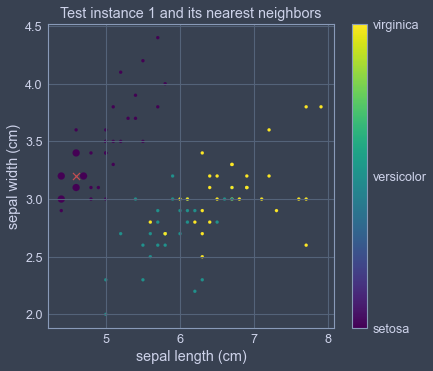

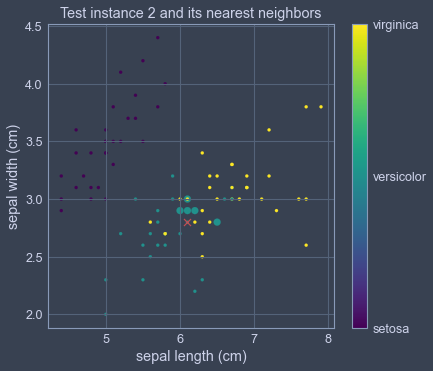

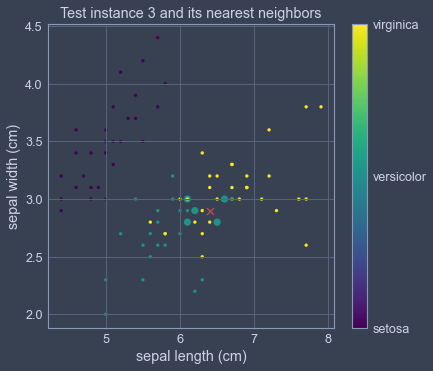

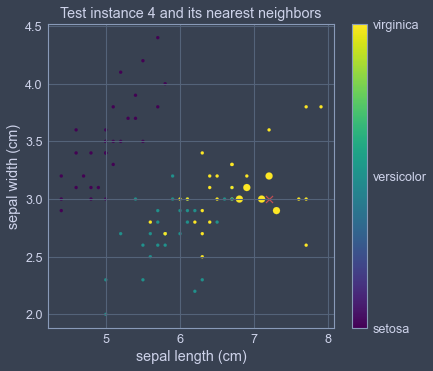

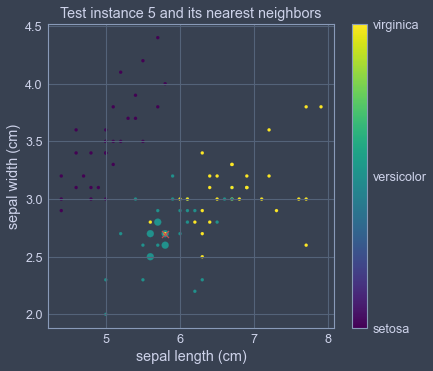

In [5]:
def plot_neighbours(X_train, Y_train, test_instance, k):
    """
    Plots all points in the dataset and shows the neighbours of a given test instance.
    """
    
    neighbours = get_neighbours(X_train, test_instance, k)
    # initialization of the sizes of the points to be plotted, size 10 
    neigh_sizes = np.ones((len(Y_train), 1)) * 10
    neigh_sizes[neighbours] = 50
    plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, s=neigh_sizes)
    plt.xlabel(iris.feature_names[0])
    plt.ylabel(iris.feature_names[1])
    plt.colorbar(ticks = [0, 1, 2], format = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)]));
    plt.scatter(test_instance[0], test_instance[1], c='r', s=50, marker='x')
    plt.show()

for i in range(5):
    test_instance = X_test[i]
    k = 5
    plt.title('Test instance %s and its nearest neighbors' % (i+1))
    plot_neighbours(X_train, Y_train, test_instance, k)

### 4. Majority vote

We have the $k$ nearest neighbours of the test set. Now we will choose a class label by majority vote.

$\ex{4.1}$ Implement the `get_majority_vote` function.

__Hint__ In the case of a split vote, pick the one that is closest.

(How to deal with the situation when counts are the same -> 
caculate the closest one's distance to the test instance;
use the pirior probability to determine;
)

In [13]:
from collections import Counter #to count unique occurances of items in array, for majority voting

def get_majority_vote(neighbour_indices, training_labels):
    """
    Given an array of nearest neighbours indices for a given test case, 
    tally up their classes to vote on the correct class for the test instance.
    :param neighbours: list of nearest neighbour indices.
    :param training_labels: the list of labels for each training instance.
    :return: the label of most common class.
    """
    
    most_common = -1
    # START ANSWER
    most_common, count = np.unique(training_labels[neighbour_indices], return_counts=True)
    # END ANSWER
    return np.max(most_common[np.where(count==np.max(count))])

predicted_label = get_majority_vote(neighbours, Y_train)
print('Your predicted label:', predicted_label)

assert predicted_label == 0
assert get_majority_vote([0,1,2,3,4], np.array([3,1,1,3,0])) == 3

# assert any([get_majority_vote([0,1,2,3,4], np.array([3,1,1,3,0])) == 3,
#            get_majority_vote([0,1,2,3,4], np.array([3,1,1,3,0])) == 1])

Your predicted label: 0


### 5. Accuracy

Now we will put all the code you wrote above together into a classifier and try to summarise the accuracy of it with the test set.

$\ex{5.1}$ Complete the `predict` function below and compute the accuracy on `X_test, Y_test`.

In [14]:
from sklearn.metrics import accuracy_score

def predict(X_train, X_test, Y_train, Y_test, k=5):
    """
    Predicts all labels for the test set, using k-nn on the training set and computes the accuracy.
    :param X_train: the training set features.
    :param X_test: the test set features.
    :param y_train: the training set labels.
    :param y_test: the test set labels.
    :return: list of predictions.
    """

    # generate predictions
    predictions = []
    # For each instance in the test set, get nearest neighbours and majority vote on predicted class
    # START ANSWER
    for x in X_test:
        predictions.append(get_majority_vote(get_neighbours(X_train, x, k), Y_train))
    # END ANSWER
    return predictions

k = 5
predictions = predict(X_train, X_test, Y_train, Y_test, k)

# summarise performance of the classification using scikit-learn
accuracy = accuracy_score(Y_test, predictions)
print('The overall accuracy of the model using scikit-learn is:', accuracy)

assert predictions == [0, 1, 1, 2, 1, 1, 2, 0, 2, 0, 2, 1, 2, 0, 0, 2, 0, 1, 2, 1, 1, 2, 2, 0, 2, 1, 1, 0, 2, 2, 1, 1, 0, 0, 0, 1, 1, 0, 1, 2, 1, 2, 0, 1, 1, 0, 0, 0, 2, 0, 2, 2, 0, 2, 1, 1, 1, 0, 0, 1]
assert np.isclose(accuracy, 0.9666666666666667)

The overall accuracy of the model using scikit-learn is: 0.9666666666666667


$\ex{5.2}$ Complete the `accuracy_score_self` and use this to compute your own accuracy, which should be the same.

In [15]:
def accuracy_score_self(Y_test, predictions):
    """
    Computes the accuracy of a test set as the fraction of items that was classified correctly.
    :param y_test: the list of true labels for the test set.
    :param y_pred: the list of predicted labels for the test set.
    :return: accuracy as a floating point.
    """

    
    accuracy = 0
    # START ANSWER
    accuracy = sum(Y_test == predictions) / (sum(Y_test == predictions) + sum(Y_test != predictions))
    # END ANSWER                                             
    return accuracy

# summarise performance of the classification
accuracy_self = accuracy_score_self(Y_test, predictions)
print('The overall accuracy of the model using your implementation of accuracy:', accuracy_self)
assert np.isclose(accuracy, accuracy_self)

The overall accuracy of the model using your implementation of accuracy: 0.9666666666666667


$\ex{5.3}$ Complete the `plot_errors` function to get a better understanding of why some points are misclassified. You can use the `plot_neighbours` function you made earlier to make a plot per misclassified point.

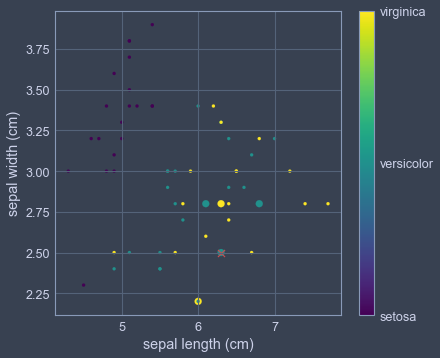

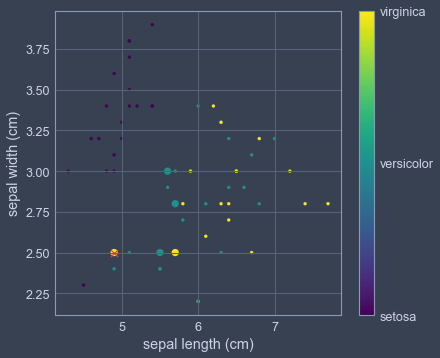

In [9]:
def plot_errors(X_train, X_test, Y_train, Y_test, predictions, k):
    """
    Plots the test points that were misclassified and their nearest neighbours using plot_neighbours.
    """
    
    # START ANSWER
    error_predictions = X_test[np.where(predictions != Y_test)]
    for test_instance in error_predictions:
        plot_neighbours(X_test, Y_test, test_instance, k)
    # END ANSWER
    return

plot_errors(X_train, X_test, Y_train, Y_test, predictions, k)

$\ex{5.4}$ Test out several values of $k$ to find the best performing $k$. Automate this process: for $k = 1...20$ compute the average accuracy over 10 repetitions (to average over randomness in train/test splits, i.e. [cross validation](https://machinelearningmastery.com/k-fold-cross-validation/)) and plot the accuracy for each $k$.

__Hint__ You can store all the results in a `[max_neighbours x n_repetitions]` NumPy array and use `np.mean` with `axis=1` to compute the mean accross the number of repetitions.

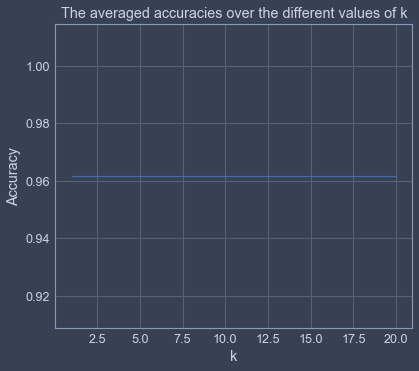

In [10]:
n_repetitions = 10
max_neighbours = 20
accuracies = np.zeros((max_neighbours, n_repetitions))
mean_accuracies = np.zeros(max_neighbours)
seeds = [x for x in range(n_repetitions)]

for i in range(n_repetitions):
    # Generate a new split of train and testset
    X_train, X_test, Y_train, Y_test = train_test_split(iris.data, iris.target, test_size=0.4, random_state=seeds[i])
    for k in range(1, max_neighbours + 1):   
    # START ANSWER
        predictions = predict(X_train, X_test, Y_train, Y_test, k)
        accuracies[k-1, i] = accuracy_score_self(Y_test, predictions)
    # END ANSWER
    
mean_accuracies = np.mean(accuracies, axis=1)

plt.plot(range(1, 21), mean_accuracies)
plt.title('The averaged accuracies over the different values of k')
plt.xlabel('k')
plt.ylabel('Accuracy');

$\q{5.2}$ What $k$ would you pick, based on your results? Does it matter a lot?

Now that we are plotting things to learn about our classifier, let's take a brief look at learning curves as well. For a learning curve, we plot the number of samples (x-axis) in the train set against the accuracy (y-axis).

$\q{5.3}$ What would you expect the learning curve to look like for the k-NN classifier?

Let's go ahead and create a learning curve.

$\ex{5.5}$ Read through the code to understand what is happening and execute to plot the learning curve. Try this for several values for $k$.

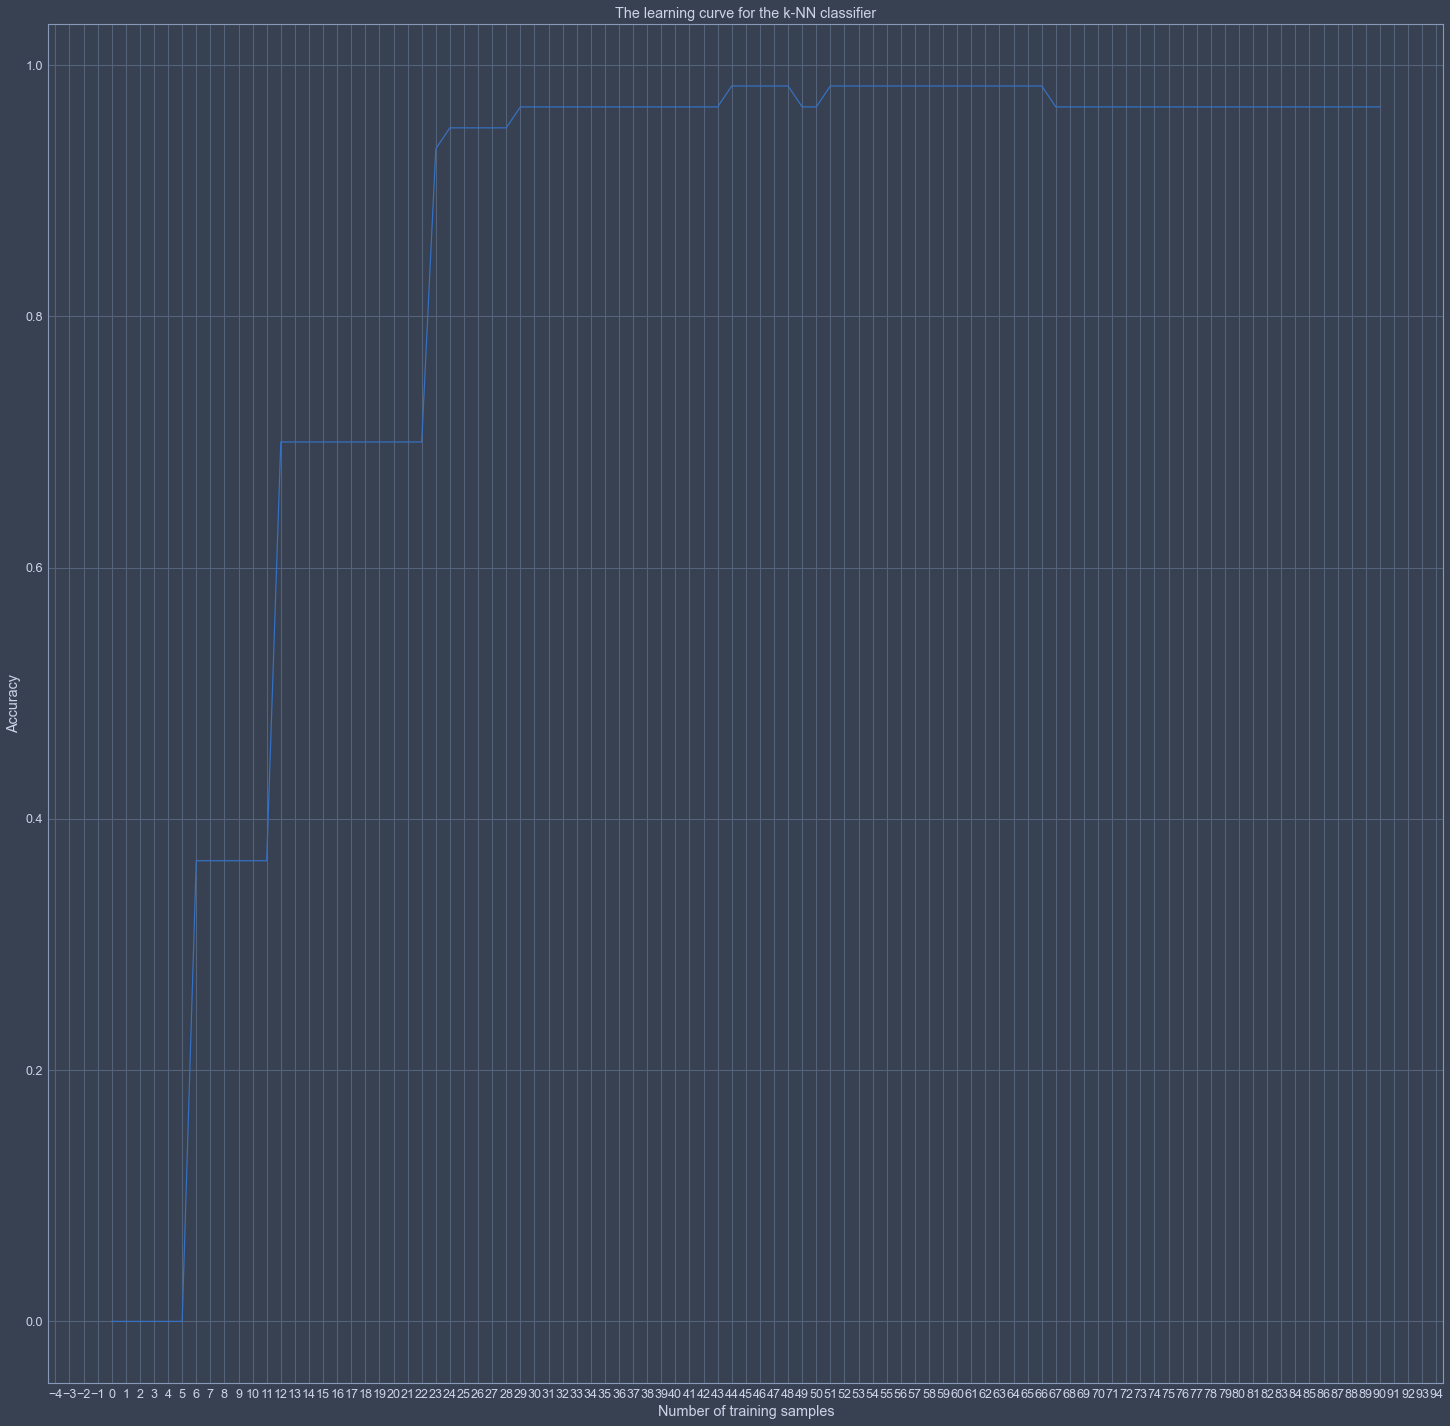

In [16]:
k = 5

X_train, X_test, Y_train, Y_test = train_test_split(iris.data, iris.target, test_size=0.4, random_state=seed)

total_samples = X_train.shape[0]
# set up array to store accuracies
accuracies = np.zeros(total_samples + 1)

# we want to learn with at least k samples and up to the size of the train set
for i in range(k, total_samples):
    predictions = predict(X_train[:i], X_test, Y_train[:i], Y_test, k)
    accuracies[i + 1] = accuracy_score(Y_test, predictions)
    
# plot learning curve
plt.figure(num=1, figsize=(25,25))
plt.plot(range(total_samples + 1), accuracies)
plt.title('The learning curve for the k-NN classifier')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
from matplotlib.pyplot import MultipleLocator
x_major_locator=MultipleLocator(1)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.show()

$\q{5.4}$ Did the learning curve resemble the expected curve? If not: why?

Because voting is a discrete process, and adding a small number of samples will influence nothing on the voting result.